# DMD on two sinusoids plus a trend

In this notebook we investigate whether DMD is able to capture the dynamics of a system that is composed of two sinusoids plus a linear temporal trend. We will generate a dataset with this structure and then apply DMD to it. The temporal trend is something that you would typically see in many time series datasets, such as global temperature data. 

In [1]:
from pydmd import BOPDMD
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_summary
from signal_generator import SignalGenerator
from matplotlib import pyplot as plt
import numpy as np

Generate the dataset using the SignalGenerator class

In [2]:
signal_generator = SignalGenerator(x_min=-5, x_max=5, t_max=60)
signal_generator.add_sinusoid1(a=2, omega=0.5, k=1.5)
signal_generator.add_sinusoid2(a=2.5, omega=4)
signal_generator.add_trend(trend=0.01, mu=0.1)
signal_generator.add_noise(random_seed=42)

Plot the individual components of the dataset and the combined dataset

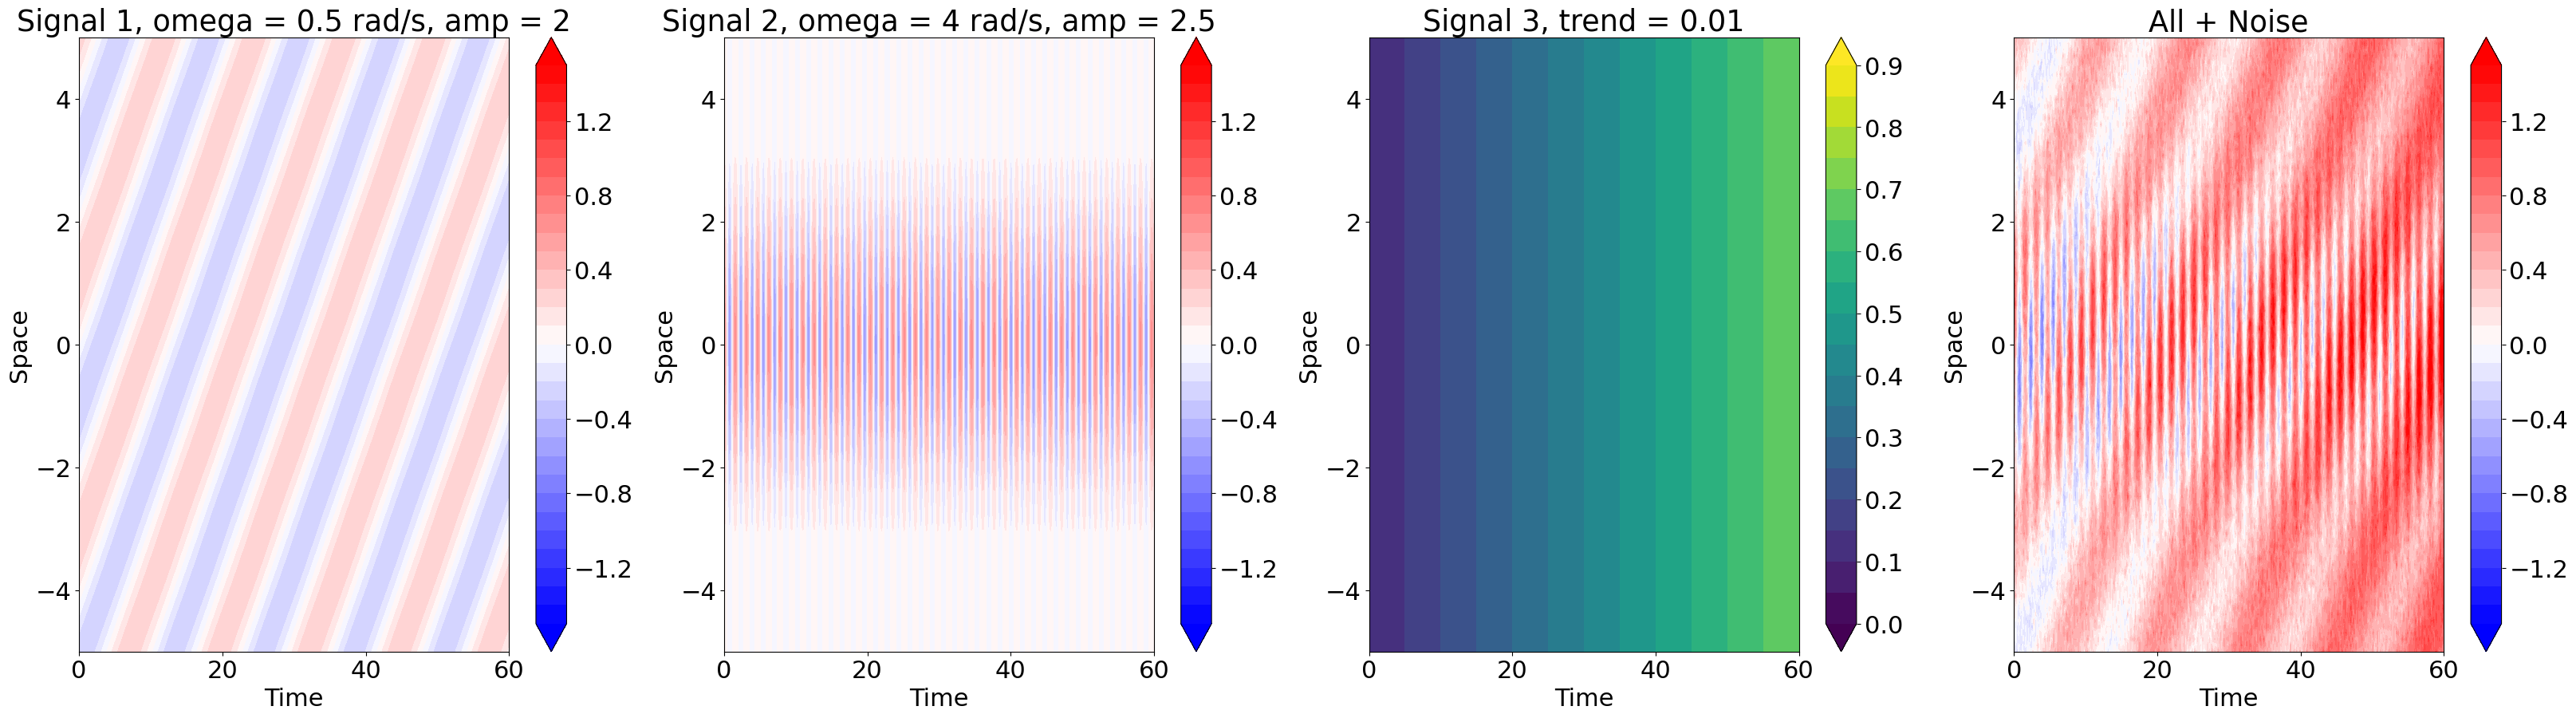

In [3]:
plt.rcParams.update({'font.size': 22})

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 4, 1)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[0]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 1, omega = {signal_generator.components[0]["omega"]} rad/s, amp = {signal_generator.components[0]["a"]}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 2)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.components[1]["signal"], levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 2, omega = {signal_generator.components[1]["omega"]} rad/s, amp = {signal_generator.components[1]["a"]}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 3)
contour = ax.contourf(
    signal_generator.T, signal_generator.X, signal_generator.components[2]["signal"], levels=np.arange(0, 0.95, 0.05), cmap='viridis', extend='both'
    )
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 3, trend = {signal_generator.components[2]["trend"]}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 4, 4)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.signal, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('All + Noise')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

## Apply DMD to the dataset
Here, we will only use Algorithm 3 of Askham and Kutz (2018) to compute the DMD modes. 

In [4]:
svd_rank = 6  # we have three signal components, so we need 6 DMD modes
delay = 2  # apply time-delay embedding

Algorithm 3: SVD is applied to the data before DMD is applied

In [5]:
optdmd = BOPDMD(svd_rank=svd_rank, num_trials=0, use_proj=True)
delay_optdmd = hankel_preprocessing(optdmd, d=delay)

Fit the DMD model to 80% of the data and predict the remaining 20%. 

In [6]:
# fit DMD model to 80% of the data
train_frac = 0.8
f_train = signal_generator.signal[:int(train_frac * signal_generator.signal.shape[0]), :]
t_train = signal_generator.t[:int(train_frac * signal_generator.signal.shape[0])]
f_test = signal_generator.signal[int(train_frac * signal_generator.signal.shape[0]):, :]
t_test = signal_generator.t[int(train_frac * signal_generator.signal.shape[0]):]

In [7]:
t_delay = t_train[:-delay+1]
delay_optdmd.fit(f_train.T, t=t_delay)

/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/toy_dataset/.venv/lib/python3.10/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


Plot the results. As can be seen, the two sinusoids seem to be well captured. DMD also captures a linear temporal trend, but its spatial structure is not well resolved (this is expected because DMD is trying to approximate this linear trend with a very slow sinusoid).

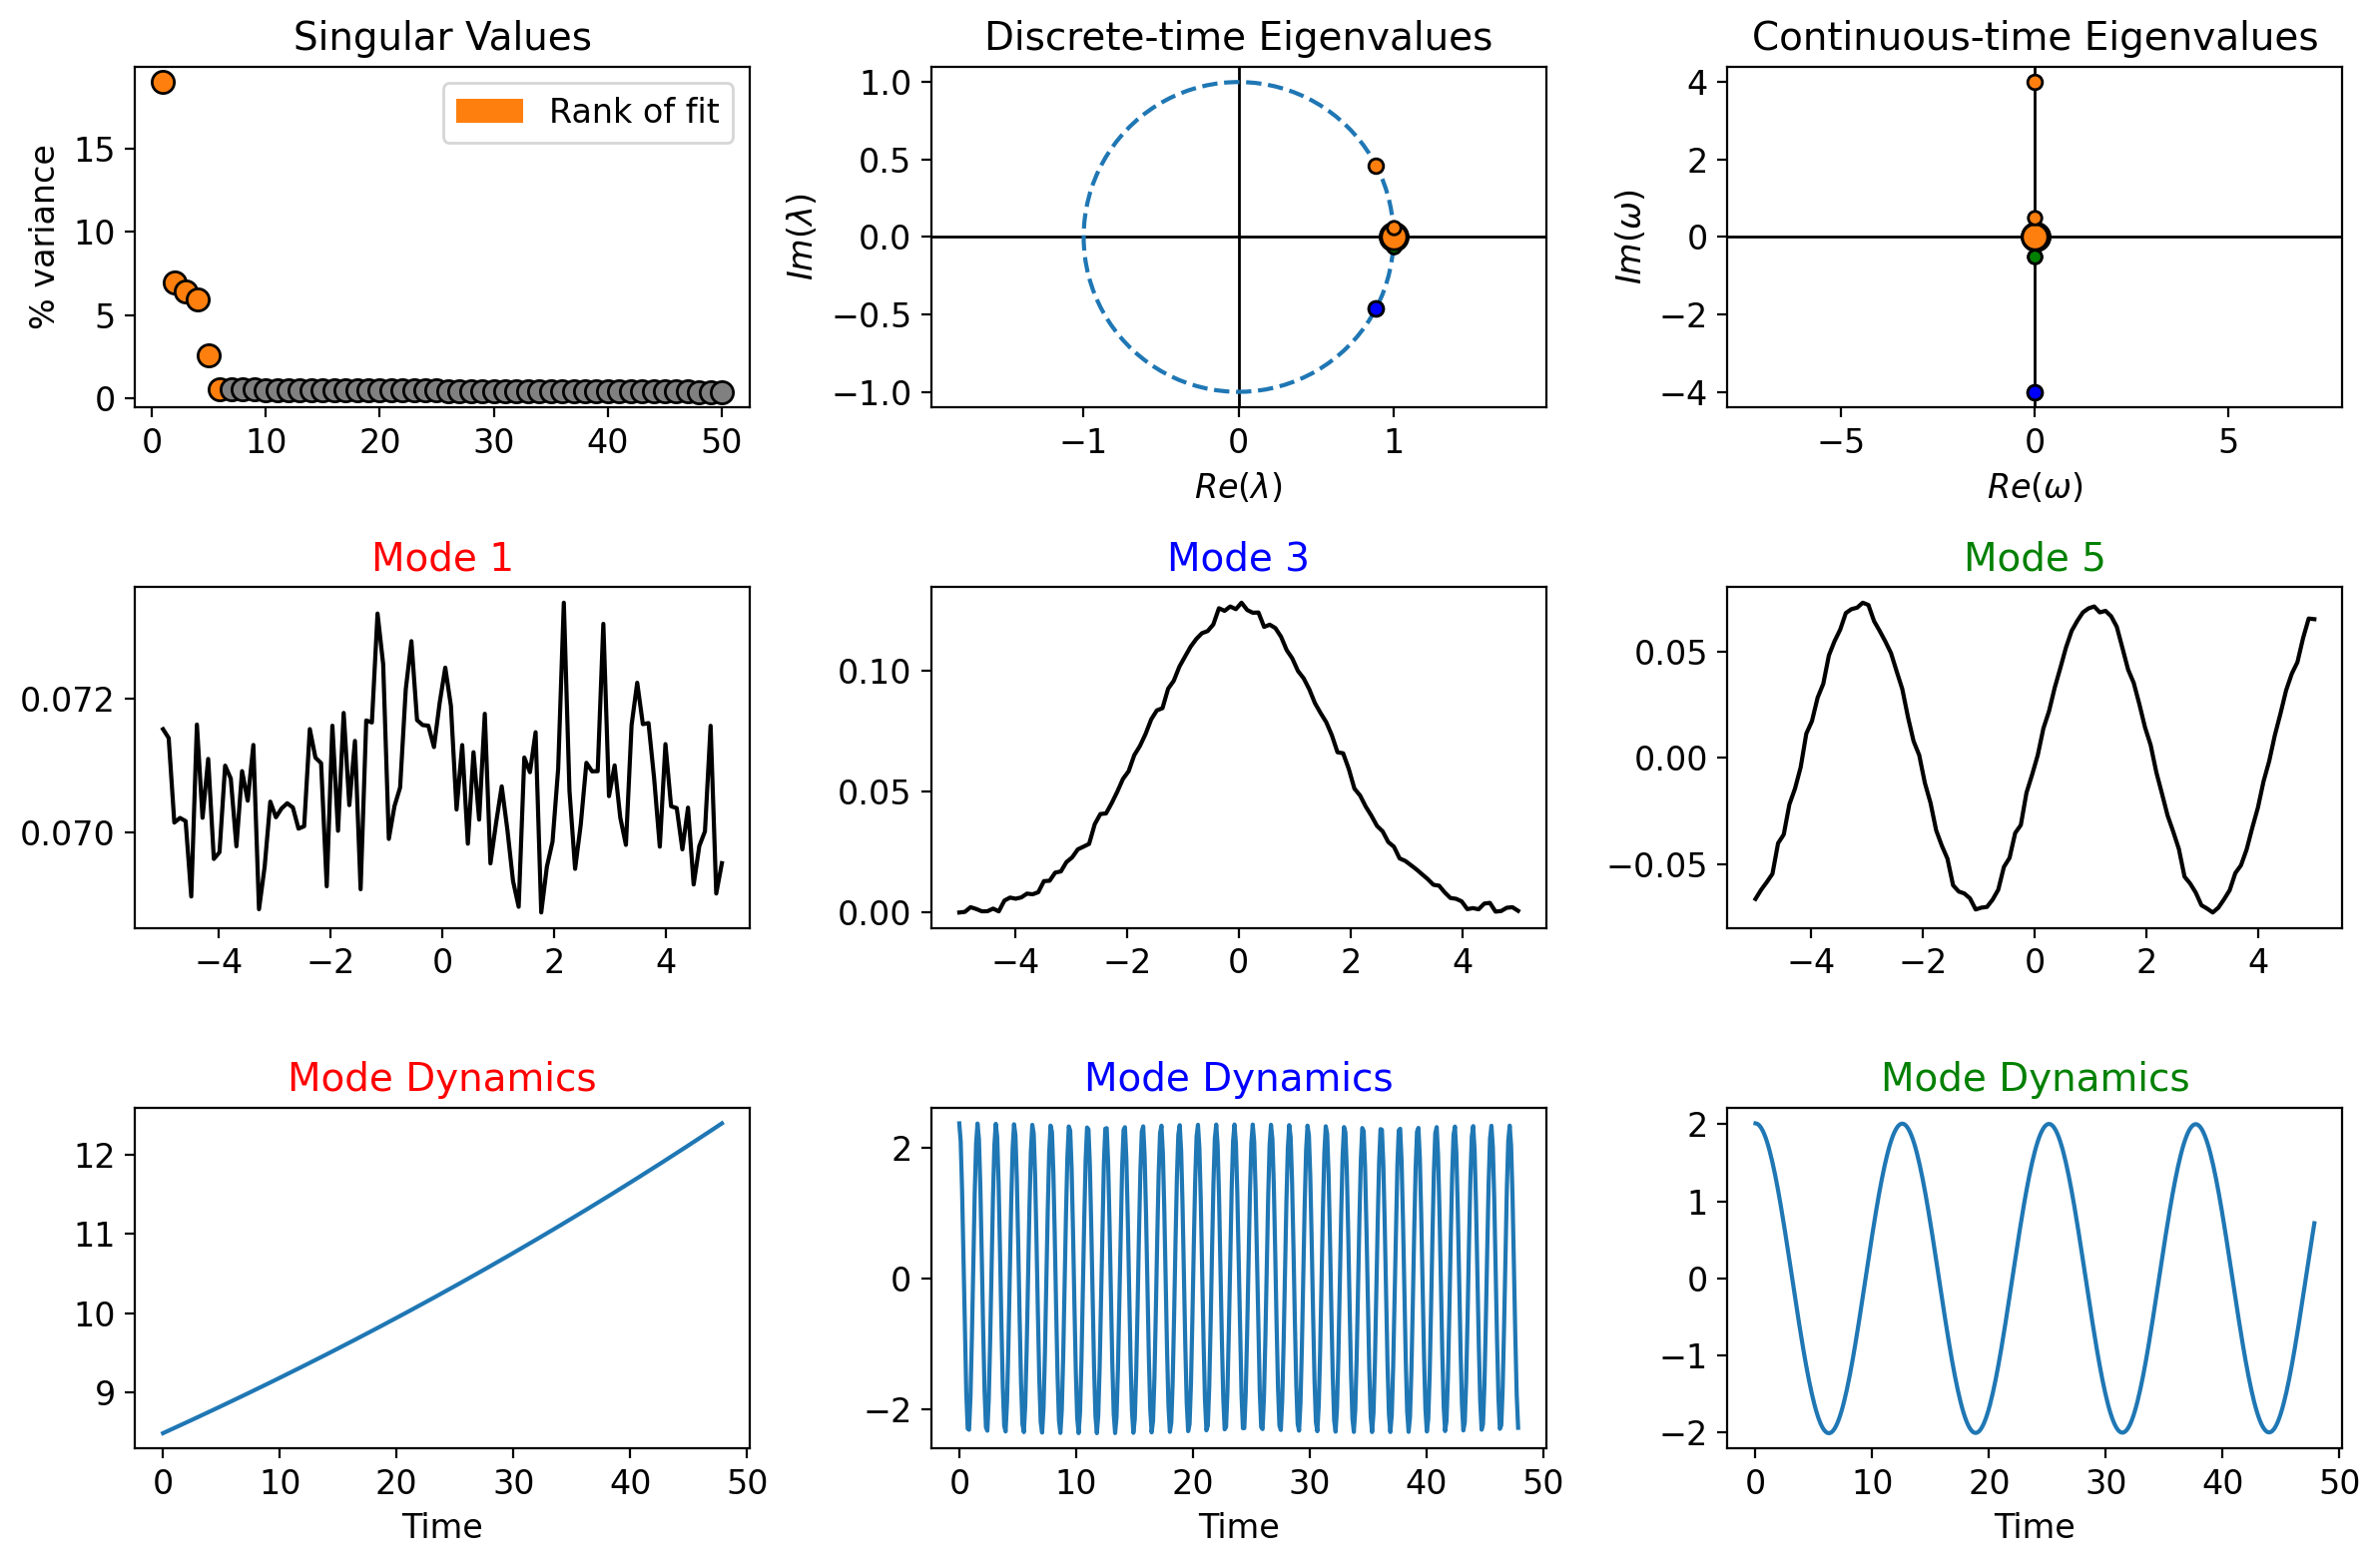

In [8]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

Inspect the predicted mode amplitudes and eigenvalues. As can be seen, the amplitudes and frequencies of the two sinusoids are well captured.

In [9]:
sorted_index = np.argsort(delay_optdmd.amplitudes)[::-1]
print(f"Amplitudes: {delay_optdmd.amplitudes[sorted_index]}")
print(f"Eigenvalues: {delay_optdmd.eigs[sorted_index]}")

Amplitudes: [8.47963412 7.05716144 2.36642131 2.36642131 2.00933786 2.00933786]
Eigenvalues: [ 0.00794277-3.43347394e-13j -0.01078681+6.50269936e-13j
 -0.00029735-3.99983316e+00j -0.00029735+3.99983316e+00j
 -0.00013967-5.00006747e-01j -0.00013967+5.00006747e-01j]


Sort the modes based on their amplitude.

In [10]:
eigs = delay_optdmd.eigs[sorted_index]
modes = delay_optdmd.modes[:, sorted_index]
dynamics = delay_optdmd.dynamics[sorted_index, :]
amps = delay_optdmd.amplitudes[sorted_index]

In [11]:
def reconstruct(mode, eig, amp, t=t_train, x_lim=signal_generator.x.shape[0]):
    """Reconstruct the signal from a single mode."""
    reconstruction = np.linalg.multi_dot([mode.reshape(-1, 1), np.diag([amp]), np.exp(np.outer(eig, t))]).real
    reconstruction = reconstruction[:x_lim, :]
    return reconstruction

Plot contours of the reconstructed data from each mode. These should ideally be the same as the individual signals that compose the data.


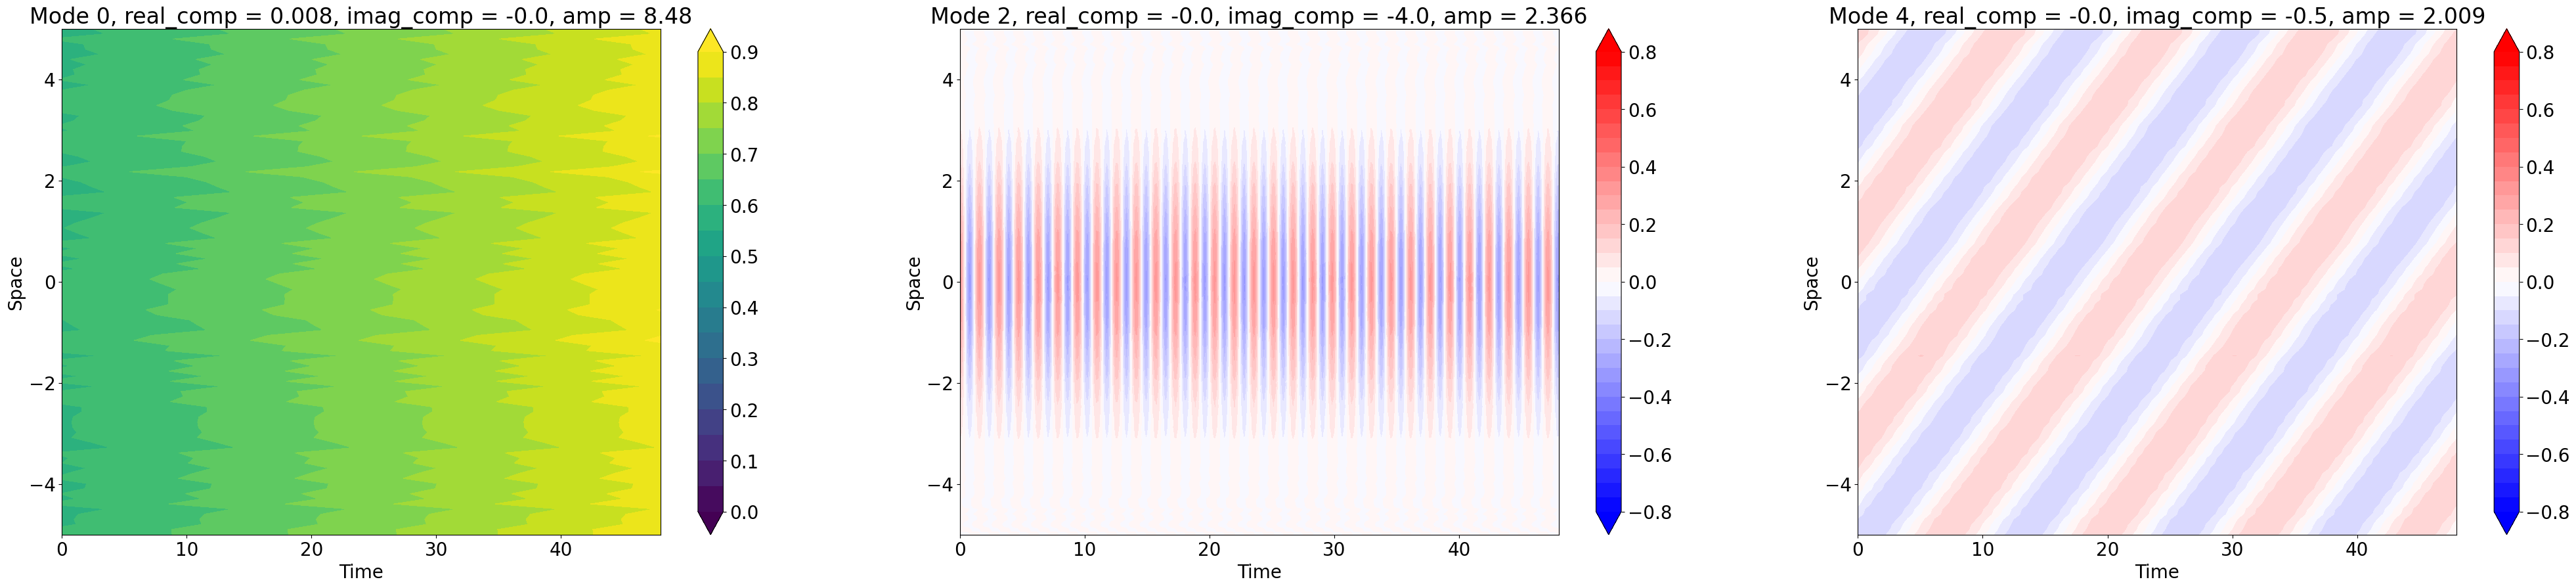

In [12]:
plt.rcParams.update({'font.size': 20}) 

fig = plt.figure(figsize=(50, 10))

which_modes = [0, 2, 4]

vmin = -0.9; vmax = 0.9

X, T = np.meshgrid(signal_generator.x, t_train)

ax = fig.add_subplot(1, 3, 1)
reconstruction = reconstruct(modes[:, which_modes[0]], eigs[which_modes[0]], amps[which_modes[0]])
levels = np.arange(0, 0.95, 0.05)
contour = ax.contourf(T, X, reconstruction.T, levels=levels, cmap='viridis', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Mode {which_modes[0]}, real_comp = {np.round(eigs[which_modes[0]].real, 3)}, imag_comp = {np.round(eigs[which_modes[0]].imag, 3)}, amp = {np.round(amps[which_modes[0]], 3)}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
reconstruction = reconstruct(modes[:, which_modes[1]], eigs[which_modes[1]], amps[which_modes[1]])
levels = np.arange(-0.8, 0.8+0.05, 0.05)
contour = ax.contourf(T, X, reconstruction.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Mode {which_modes[1]}, real_comp = {np.round(eigs[which_modes[1]].real, 3)}, imag_comp = {np.round(eigs[which_modes[1]].imag, 3)}, amp = {np.round(amps[which_modes[1]], 3)}')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 3)
reconstruction = reconstruct(modes[:, which_modes[2]], eigs[which_modes[2]], amps[which_modes[2]])
levels = np.arange(-0.8, 0.8+0.05, 0.05)
contour = ax.contourf(T, X, reconstruction.T, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Mode {which_modes[2]}, real_comp = {np.round(eigs[which_modes[2]].real, 3)}, imag_comp = {np.round(eigs[which_modes[2]].imag, 3)}, amp = {np.round(amps[which_modes[2]], 3)}')
plt.colorbar(contour, ax=ax, orientation="vertical")


Produce a forecast and compare to the data we held out.

In [13]:
forecast = delay_optdmd.forecast(t_test)
forecast = forecast[:signal_generator.x.shape[0], :]  # note than need to do this because of the time delay embedding
forecast = forecast.T
forecast = forecast.real

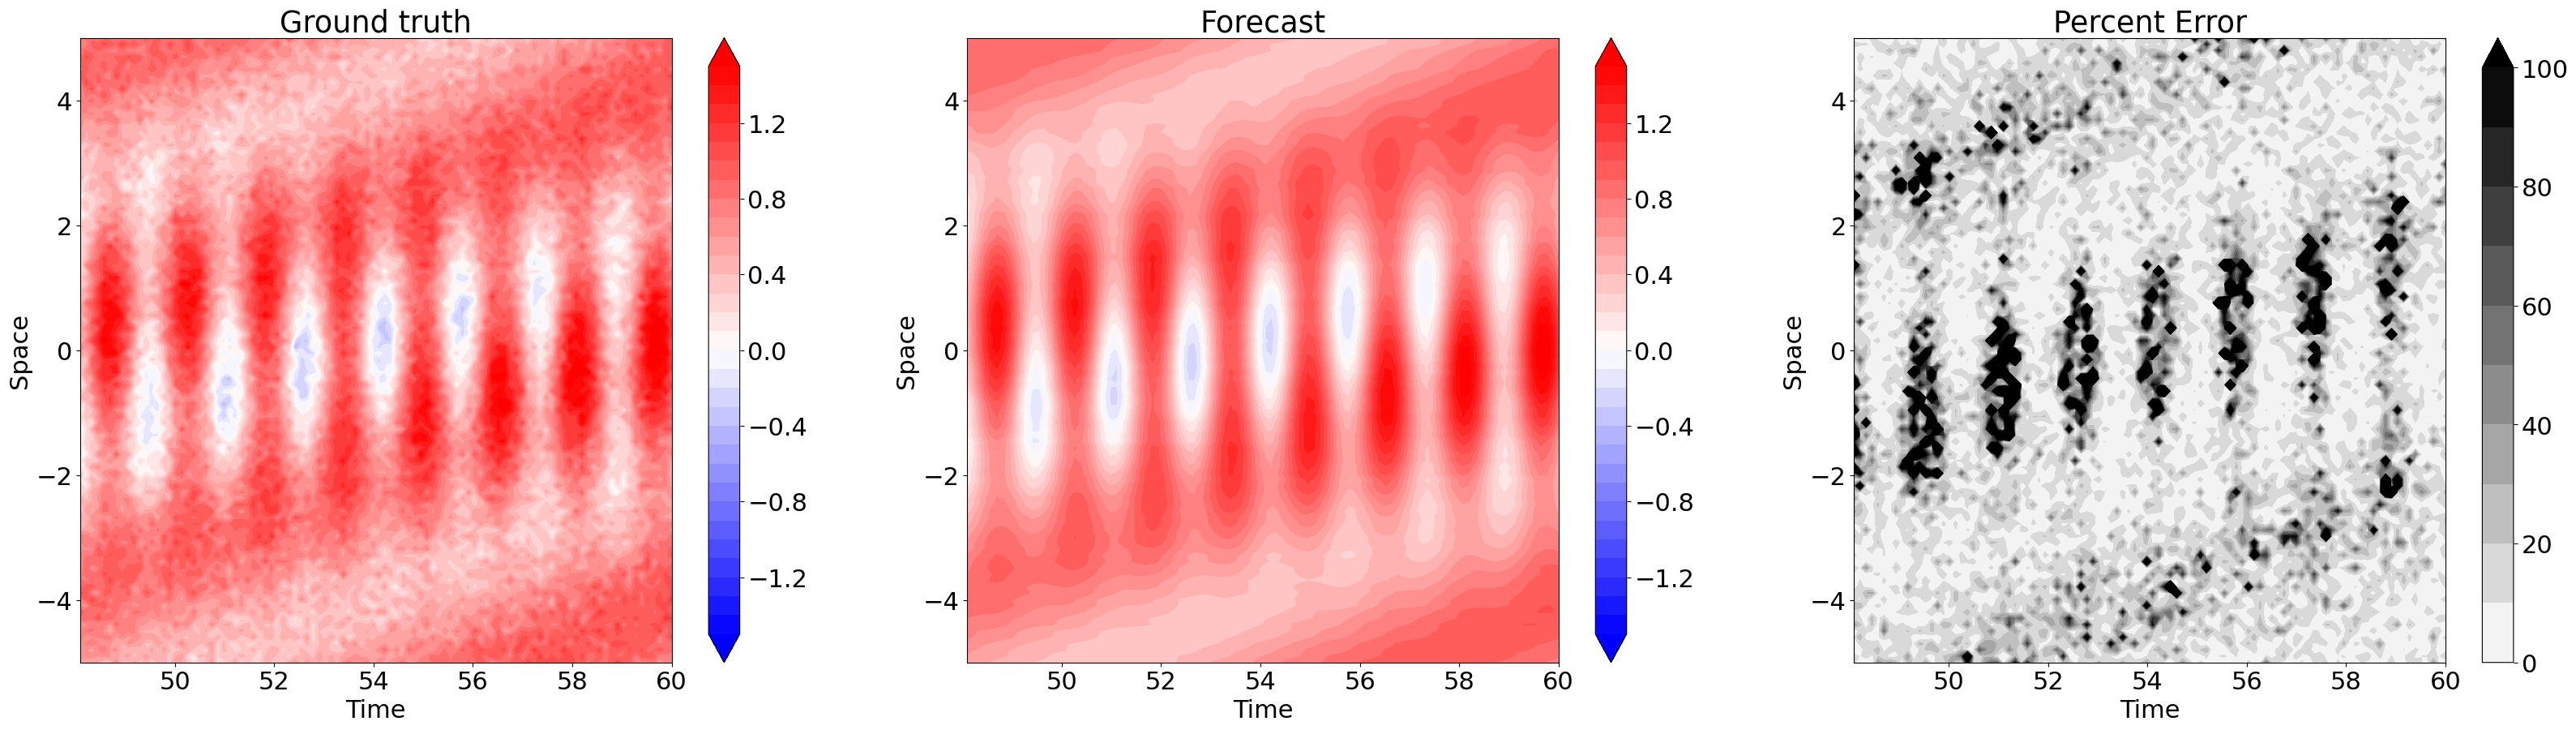

In [14]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.5; vmax = 1.5
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, f_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(f_test - forecast) / np.abs(f_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

## Conclusion

DMD is able to capture the dynamics of a system that is composed of two sinusoids plus a linear temporal trend. However, the spatial structure of the linear trend is not well resolved. This is expected because DMD is trying to approximate this linear trend with a very slow sinusoid. However, the two sinusoids are well captured in terms of their spatial structure, amplitude and temporal dynamics.